In [1]:
import numpy as np
import pandas as pd
import cv2
import numba
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
window_size = 50
randomisations = 100

In [3]:
post0_x = 3.0 * np.cos(3.5 * np.pi / 18)
post0_y = 3.0 * -np.sin(3.5 * np.pi / 18)

post1_x = 3.0
post1_y = 0.0

post2_x = 3.0 * np.cos(3.5 * np.pi / 18)
post2_y = 3.0 * np.sin(3.5 * np.pi / 18)

In [4]:
df = pd.read_csv("three-choice.csv")

xs = df['rotated_x'].values
ys = df['rotated_y'].values
ts = df['t2'].values
    
xs = np.concatenate((xs, xs))
ys = np.concatenate((ys, -ys))
ts = np.concatenate((ts, ts))

In [5]:
nbins = 500
peak_threshold = 0.9


def density_map(x, y, stats=True):
    blur = (11, 11) if stats == True else (101, 101)
    r = [[0, post1_x], [post0_y, post2_y]]
    
    h, xedge, yedge, image = plt.hist2d(x, y, bins=nbins, normed=True, range=r)
    tmp_img = np.flipud(np.rot90(cv2.GaussianBlur(h, blur, 0)))
    
    tmp_img /= np.max(tmp_img)

    return tmp_img

In [6]:
def fitfunc(x, p, q, r):
    return r * (np.abs((x - p)) ** q)


def fitfunc_vec_self(x, p, q, r):
    y = np.zeros(x.shape)
    for i in range(len(y)):
        y[i] = fitfunc(x[i], p, q, r)
    return y

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  if __name__ == '__main__':


10
20
30
40
50
60
60
70
80
90


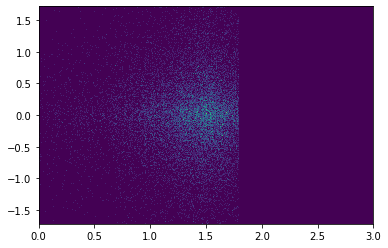

In [7]:
positive_bif = []

while True:
    x_fit = []
    y_fit = []

    bif_pt = 0.5
    params1 = [0.8, 1, 0.5]

    xs1 = xs[xs < 1.8]
    ys1 = ys[xs < 1.8]
    ts1 = ts[xs < 1.8]

    x_sub = np.concatenate((xs1, xs1))
    y_sub = np.concatenate((ys1, -ys1))
    np.random.shuffle(y_sub)
    t_sub = np.concatenate((ts1, ts1))

    tmin = 0
    tmax = 200
    for idx, t in enumerate(range(tmin, tmax-window_size, 12)):
        window_min = t
        window_max = t + window_size

        x = x_sub[(t_sub > window_min) & (t_sub < window_max)]
        y = y_sub[(t_sub > window_min) & (t_sub < window_max)]
        tmp_img2 = density_map(x, y, stats=True)

        if idx == 0:
            tmp_img = tmp_img2
        else:
            tmp_img = np.fmax(tmp_img2, tmp_img)

    x_fit = np.where(tmp_img > peak_threshold)[1] * post1_x / nbins
    y_fit = (
        np.where(tmp_img > peak_threshold)[0] * (post0_y - post2_y) / nbins + post2_y
    )

    x_fit = x_fit
    y_fit = np.abs(y_fit)
    y_fit = y_fit[x_fit > bif_pt]
    x_fit = x_fit[x_fit > bif_pt]

    try:
        for i in range(0, 10):
            fit_params, pcov = curve_fit(
                fitfunc_vec_self, x_fit, y_fit, p0=params1, maxfev=10000
            )
            params1 = fit_params

        if (
            (params1[0] > 0)
            & (params1[0] < post0_x)
            & (params1[1] > 0.1)
            & (params1[2] > 0.1)
        ):
            positive_bif.append(1)
        else:
            positive_bif.append(0)
    except RuntimeError:
        pass

    if len(positive_bif) >= randomisations:
        break

    if len(positive_bif) % 10 == 0:
        print(len(positive_bif))

In [8]:
np.sum(positive_bif) / len(positive_bif), len(positive_bif)

(0.0, 100)

#### Get the first bifurcation point (without randomisations)
Once you have this, you can draw a line segment bisecting the angle between the point and two targets. This will be the line about which you symmetrise to get the second bifurcation point

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  if __name__ == '__main__':


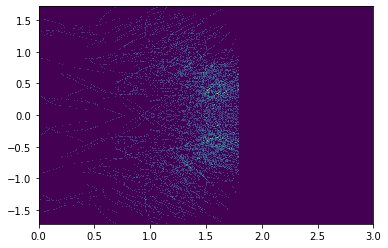

In [7]:
x_fit = []
y_fit = []

bif_pt = 0.5
params1 = [0.8, 1, 0.5]

xs1 = xs[xs < 1.8]
ys1 = ys[xs < 1.8]
ts1 = ts[xs < 1.8]

x_sub = np.concatenate((xs1, xs1))
y_sub = np.concatenate((ys1, -ys1))
t_sub = np.concatenate((ts1, ts1))

tmin = 0
tmax = 200
for idx, t in enumerate(range(tmin, tmax-window_size)):
    window_min = t
    window_max = t + window_size

    x = x_sub[(t_sub > window_min) & (t_sub < window_max)]
    y = y_sub[(t_sub > window_min) & (t_sub < window_max)]
    tmp_img2 = density_map(x, y, stats=True)

    if idx == 0:
        tmp_img = tmp_img2
    else:
        tmp_img = np.fmax(tmp_img2, tmp_img)

x_fit = np.where(tmp_img > peak_threshold)[1] * post1_x / nbins
y_fit = (
    np.where(tmp_img > peak_threshold)[0] * (post0_y - post2_y) / nbins + post2_y
)

x_fit = x_fit
y_fit = np.abs(y_fit)
y_fit = y_fit[x_fit > bif_pt]
x_fit = x_fit[x_fit > bif_pt]

for i in range(0, 10):
    fit_params, pcov = curve_fit(
        fitfunc_vec_self, x_fit, y_fit, p0=params1, maxfev=10000
    )
    params1 = fit_params

In [8]:
bisector_xs = [params1[0], post2_x]
bisector_ys = [
    0,
    np.tan(np.arctan2(post2_y, post2_x - params1[0]) / 2) * (post2_x - params1[0]),
]

#### Get the second bifurcation point
For this, you must center the trajectories about the bifurcation point, get a new heatmap and rotate this by the angle of the bisector line

In [9]:
# center points about the first bifurcation
cxs = xs - params1[0]
cys = ys
cts = ts

cpost0_x = post0_x - params1[0]
cpost1_x = post1_x - params1[0]
cpost2_x = post2_x - params1[0]

In [10]:
@numba.njit(fastmath=True, parallel=True)
def parallel_rotate(xy, rmat):
    out = np.zeros(xy.shape)
    for idx in numba.prange(xy.shape[0]):
        out[idx] = np.dot(rmat[idx], xy[idx])
    return out

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  if __name__ == '__main__':
/home/user/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:1097: RuntimeWarning: invalid value encountered in true_divide
  hist /= s
/home/user/.local/lib/python3.6/site-packages/matplotlib/colors.py:885: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/user/.local/lib/python3.6/site-packages/numpy/ma/core.py:713: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


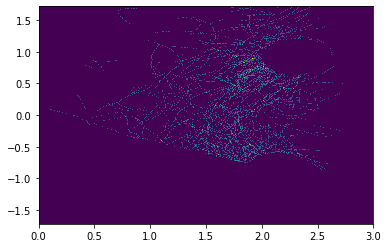

In [11]:
# clip all points to the left of and below 0 and points beyond post centers
ccxs = cxs[cxs > 0]
ccys = cys[cxs > 0]
ccts = cts[cxs > 0]
ccxs = ccxs[ccys > 0]
ccts = ccts[ccys > 0]
ccys = ccys[ccys > 0]

xy = np.concatenate((ccxs.reshape(-1, 1), ccys.reshape(-1, 1)), axis=1)
angle = np.full(ccxs.shape, np.arctan2(post2_y, post2_x - params1[0]) / 2)
rmat = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]).T
rx, ry = parallel_rotate(xy, rmat).T

blur = (101, 101)

r1 = [[0, post1_x], [post0_y, post2_y]]

tmin = 0
tmax = 270
for idx, t in enumerate(range(tmin, tmax)):
    window_min = t
    window_max = t + window_size

    x = rx[(ccts > window_min) & (ccts < window_max)]
    y = ry[(ccts > window_min) & (ccts < window_max)]
    tmp_img = density_map(x, y, stats=False)

    if idx == 0:
        tmp_img1 = tmp_img
    else:
        tmp_img1 = np.fmax(tmp_img1, tmp_img)

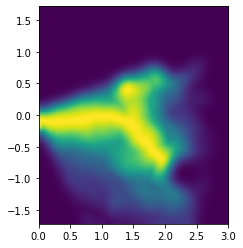

In [12]:
plt.imshow(tmp_img1, extent=[r1[0][0], r1[0][1], r1[1][0], r1[1][1]])

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
  if __name__ == '__main__':


10
20
30
40


/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  


50
60
70
80
90


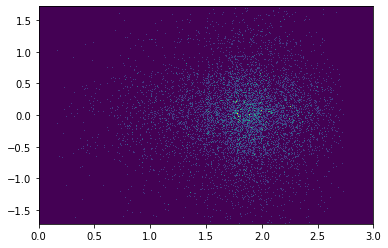

In [13]:
positive_bif2 = []

while True:
    bif_pt = 1.2
    params2 = [1.4, 1, 0.5]

    x_sub = np.concatenate((rx, rx))
    y_sub = np.concatenate((ry, -ry))
    np.random.shuffle(y_sub)
    t_sub = np.concatenate((ccts, ccts))

    tmin = 0
    tmax = 300
    for idx, t in enumerate(range(tmin, tmax, 20)):
        window_min = t
        window_max = t + window_size

        x = x_sub[(t_sub > window_min) & (t_sub < window_max)]
        y = y_sub[(t_sub > window_min) & (t_sub < window_max)]
        tmp_img = density_map(x, y, stats=False)

        if idx == 0:
            tmp_img1 = tmp_img
        else:
            tmp_img1 = np.fmax(tmp_img1, tmp_img)

    x_fit = np.where(tmp_img1 > peak_threshold)[1] * post1_x / nbins
    y_fit = np.where(tmp_img1 > peak_threshold)[0] * (post0_y - post2_y) / nbins + post2_y

    x_fit = x_fit
    y_fit = np.abs(y_fit)
    y_fit = y_fit[x_fit > bif_pt]
    x_fit = x_fit[x_fit > bif_pt]

    try:
        for i in range(0, 10):
            fit_params, pcov = curve_fit(
                fitfunc_vec_self, x_fit, y_fit, p0=params2, maxfev=10000
            )
            params2 = fit_params

        if (
            (fit_params[0] > 0)
            & (fit_params[0] < post0_x)
            & (fit_params[1] > 0.1)
            & (fit_params[2] > 0.1)
        ):
            positive_bif2.append(1)
        else:
            positive_bif2.append(0)
    except TypeError:
        pass

    if len(positive_bif2) >= randomisations:
        break

    if len(positive_bif2) % 10 == 0:
        print(len(positive_bif2))

In [14]:
np.sum(positive_bif2) / len(positive_bif2), len(positive_bif2)

(0.0, 100)